# ALPHALENS RELOADED

Alphalens is another excellent quant finance package that was developed by Quantopian. Alphalens Reloaded is that same package, but maintenance has been taken over by the incredibly wonderful Stefan Jansen. We are all in his debt for Zipline Reloaded and Alphalens Reloaded and PyFolio Reloaded and bcolz Reloaded and man Stefan is doing more than his part for home quants. Send him your thanks.

You can install alphalens-reloaded with conda:

! conda install -c ml4f alphalens-reloaded

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

In [3]:
sns.set_style('whitegrid')
%matplotlib inline

## Load Zipline Results

In [4]:
results = pd.read_pickle('single_factor.pickle')

In [5]:
results.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 21:00:00+00:00 to 2017-12-29 21:00:00+00:00
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   period_open              755 non-null    datetime64[ns, UTC]
 1   period_close             755 non-null    datetime64[ns, UTC]
 2   starting_exposure        755 non-null    float64            
 3   net_leverage             755 non-null    float64            
 4   ending_exposure          755 non-null    float64            
 5   starting_value           755 non-null    float64            
 6   ending_value             755 non-null    float64            
 7   starting_cash            755 non-null    float64            
 8   ending_cash              755 non-null    float64            
 9   portfolio_value          755 non-null    float64            
 10  returns                  755 non-null    float64 

In [6]:
price_frame = pd.concat([df.to_frame(d) for d, df in results.prices.dropna().items()], axis=1).T
price_frame.columns = [re.findall(r"\[(.+)]", str(col))[0] for col in price_frame.columns]
price_frame.index = price_frame.index.normalize()
price_frame.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 754 entries, 2015-01-05 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 1649 entries, A to NETE
dtypes: float64(1649)
memory usage: 9.5 MB


In [7]:
factor_frame = pd.concat([df.to_frame(d) for d, df in results.factor_data.dropna().items()], axis=1).T
factor_frame.columns = [re.findall(r"\[(.+)\]", str(col))[0] for col in factor_frame.columns]
factor_frame.index = factor_frame.index.normalize()
factor_frame = factor_frame.stack()
factor_frame.index.names = ['date', 'asset']
factor_frame.head()

date                       asset
2015-01-05 00:00:00+00:00  A        2707.0
                           AAL       870.0
                           AAP      1253.0
                           AAPL     2977.0
                           ABBV     2806.0
dtype: float64

## Load S&P500 Index

In [8]:
data_path = 'asset_data.h5'
with pd.HDFStore(data_path) as store:
    sp500_index = store['historical_sp500']

In [9]:
sp500_index['Date'] = pd.to_datetime(sp500_index['Date'])

In [10]:
sp500_index = sp500_index.set_index('Date')['Close'].resample('D').ffill()
sp500_index

Date
1789-05-01       0.51
1789-05-02       0.51
1789-05-03       0.51
1789-05-04       0.51
1789-05-05       0.51
               ...   
2021-08-28    4509.37
2021-08-29    4509.37
2021-08-30    4528.79
2021-08-31    4522.68
2021-09-01    4524.09
Freq: D, Name: Close, Length: 84860, dtype: float64

In [11]:
sp500_index = sp500_index.tz_localize('utc').filter(price_frame.index.get_level_values(0))
sp500_index

Date
2015-01-05 00:00:00+00:00    2020.58
2015-01-06 00:00:00+00:00    2002.61
2015-01-07 00:00:00+00:00    2025.90
2015-01-08 00:00:00+00:00    2062.14
2015-01-09 00:00:00+00:00    2044.81
                              ...   
2017-12-22 00:00:00+00:00    2683.34
2017-12-26 00:00:00+00:00    2680.50
2017-12-27 00:00:00+00:00    2682.62
2017-12-28 00:00:00+00:00    2687.54
2017-12-29 00:00:00+00:00    2673.61
Name: Close, Length: 754, dtype: float64

## Alphalens

In [12]:
import alphalens

In [13]:
HOLDING_PERIODS = (5, 10, 21, 42)
QUANTILES = 5
alphalens_data = alphalens.utils.get_clean_factor_and_forward_returns(factor=factor_frame,
                                                               prices=price_frame,
                                                               periods=HOLDING_PERIODS,
                                                               quantiles=QUANTILES)

Dropped 5.6% entries from factor data: 5.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [14]:
alphalens_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 710849 entries, (Timestamp('2015-01-05 00:00:00+0000', tz='UTC', freq='C'), 'A') to (Timestamp('2017-10-30 00:00:00+0000', tz='UTC', freq='C'), 'SEM')
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   5D               710849 non-null  float64
 1   10D              710849 non-null  float64
 2   21D              710849 non-null  float64
 3   42D              710849 non-null  float64
 4   factor           710849 non-null  float64
 5   factor_quantile  710849 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 35.3+ MB


In [15]:
alphalens_data.head()

5D       10D       21D       42D  \
date                      asset                                           
2015-01-05 00:00:00+00:00 A      0.007789 -0.046985 -0.027889  0.072864   
                          AAL   -0.079722 -0.020882 -0.095684 -0.103295   
                          AAP    0.015722 -0.024350 -0.003196 -0.010865   
                          AAPL   0.028235  0.023247  0.116518  0.214965   
                          ABBV   0.017169 -0.018561 -0.061098 -0.064811   

                                 factor  factor_quantile  
date                      asset                           
2015-01-05 00:00:00+00:00 A      2707.0                5  
                          AAL     870.0                1  
                          AAP    1253.0                2  
                          AAPL   2977.0                5  
                          ABBV   2806.0                5

In [16]:
alphalens_data.reset_index().to_csv('alphalens_data.csv', index=False)

## Tear Sheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,1.0,1011.0,303.057978,188.562449,142313,20.020145
2,352.0,1636.0,856.678631,234.705707,142117,19.992572
3,794.0,2153.0,1417.174265,259.942787,142019,19.978786
4,1273.0,2621.0,1979.178578,253.504821,142117,19.992572
5,1827.0,3050.0,2519.578804,227.348609,142283,20.015925


Returns Analysis


,5D,10D,21D,42D
Ann. alpha,0.046,0.036,0.009,0.001
beta,0.083,0.098,0.077,0.019
Mean Period Wise Return Top Quantile (bps),11.724,9.110,3.948,-0.376
Mean Period Wise Return Bottom Quantile (bps),-16.862,-13.259,-4.742,-1.979
Mean Period Wise Spread (bps),28.587,22.343,8.711,1.582


Information Analysis


,5D,10D,21D,42D
IC Mean,0.022,0.026,0.017,0.003
IC Std.,0.140,0.127,0.116,0.115
Risk-Adjusted IC,0.160,0.207,0.148,0.027
t-stat(IC),4.261,5.529,3.953,0.729
p-value(IC),0.000,0.000,0.000,0.466
IC Skew,0.372,0.266,0.115,0.113
IC Kurtosis,0.054,-0.515,-0.333,-0.557


Turnover Analysis


,5D,10D,21D,42D
Quantile 1 Mean Turnover,0.411,0.590,0.830,0.831
Quantile 2 Mean Turnover,0.645,0.740,0.804,0.812
Quantile 3 Mean Turnover,0.679,0.765,0.808,0.812
Quantile 4 Mean Turnover,0.642,0.741,0.810,0.814
Quantile 5 Mean Turnover,0.394,0.569,0.811,0.819


,5D,10D,21D,42D
Mean Factor Rank Autocorrelation,0.713,0.454,-0.013,-0.017


<Figure size 432x288 with 0 Axes>

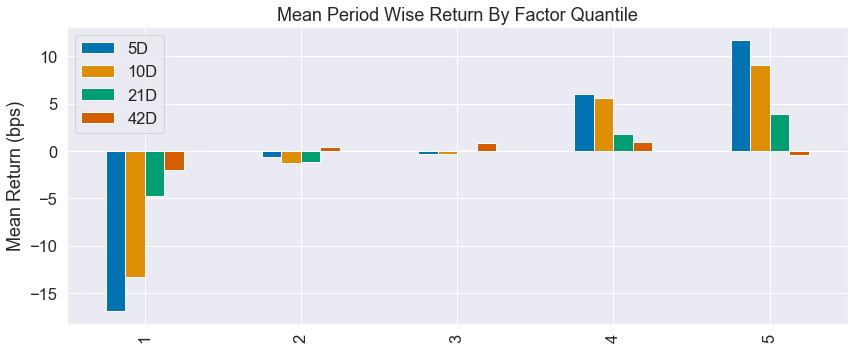

In [17]:
alphalens.tears.create_summary_tear_sheet(alphalens_data)

## Predictive Performance by Factor Quantiles - Returns Analysis

In [18]:
mean_return_by_quantile, std_err = alphalens.performance.mean_return_by_quantile(alphalens_data)
mean_return_by_quantile_normalized = mean_return_by_quantile.apply(lambda x: x.add(1).pow(1/int(x.name[:-1])).sub(1))

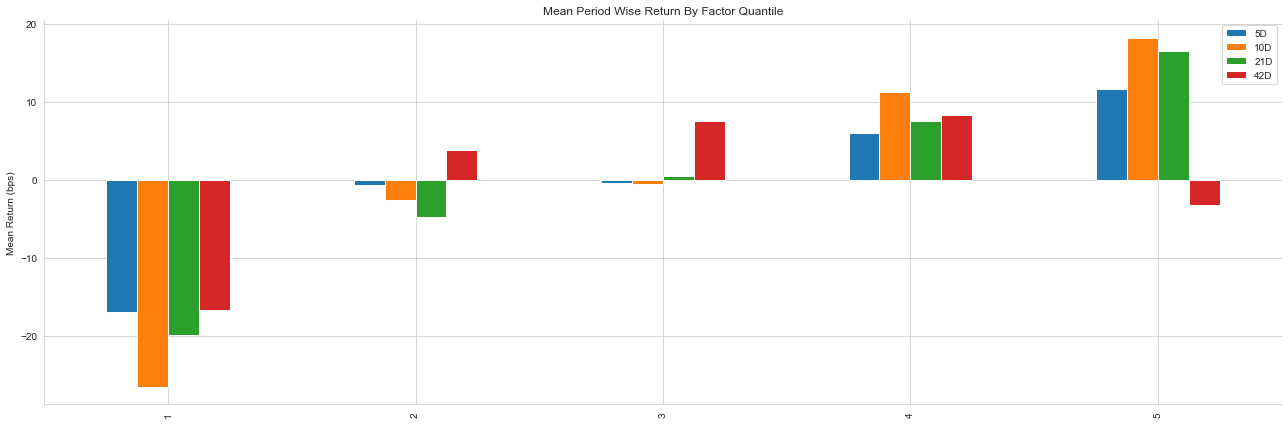

In [19]:
alphalens.plotting.plot_quantile_returns_bar(mean_return_by_quantile)
plt.tight_layout()
sns.despine();

In [20]:
mean_return_by_quantile_daily, std_err = alphalens.performance.mean_return_by_quantile(alphalens_data, by_date=True)

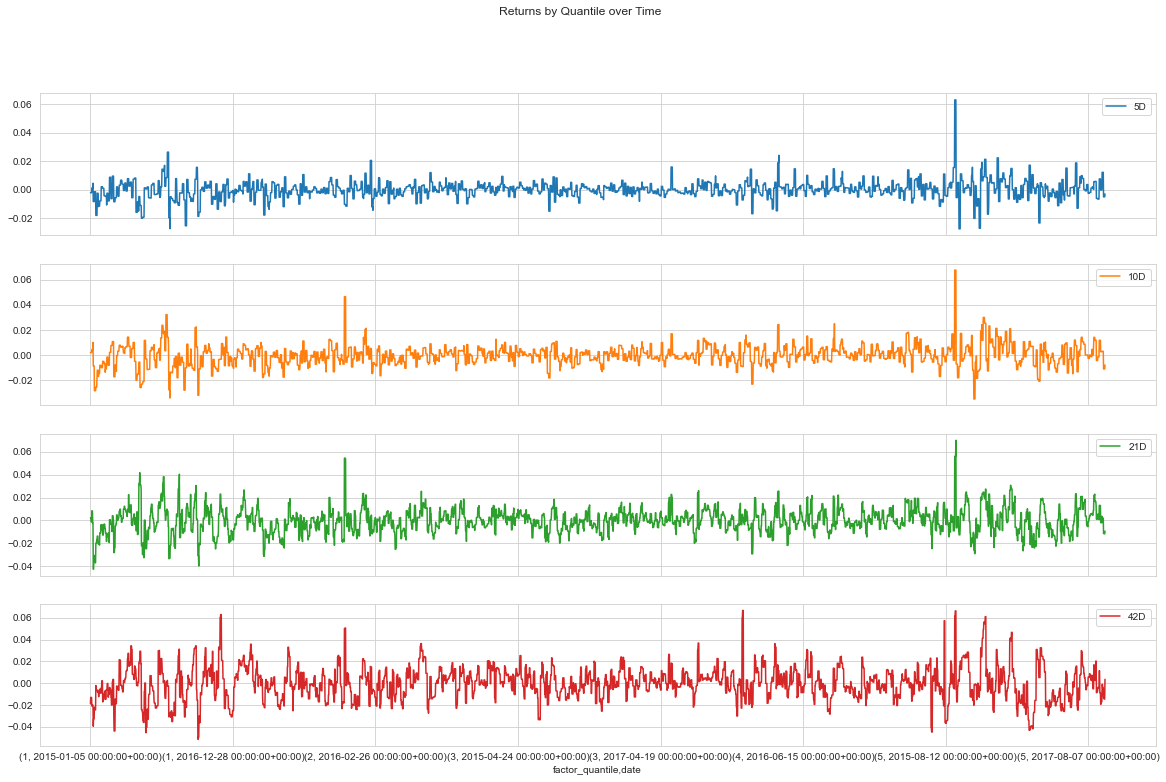

In [21]:
mean_return_by_quantile_daily.plot(figsize=(20,12), subplots=True, title='Returns by Quantile over Time');

## Cumulative Returns by Quantile

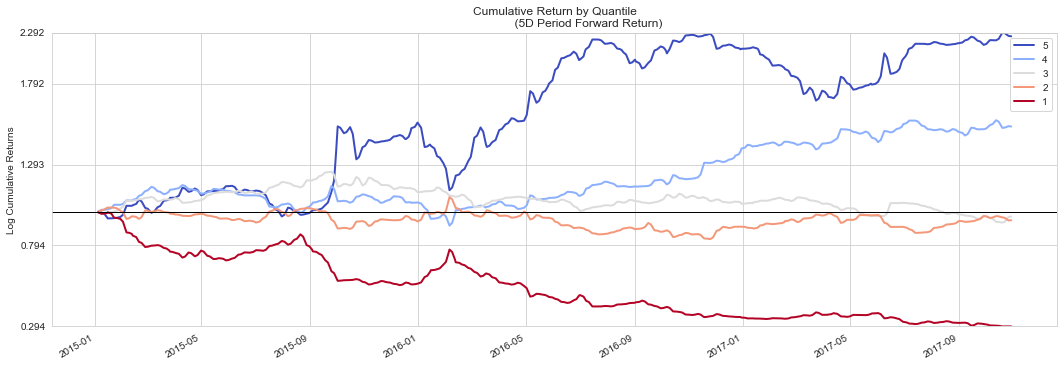

In [22]:
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_quantile_daily['5D'], period='5D', freq=None);

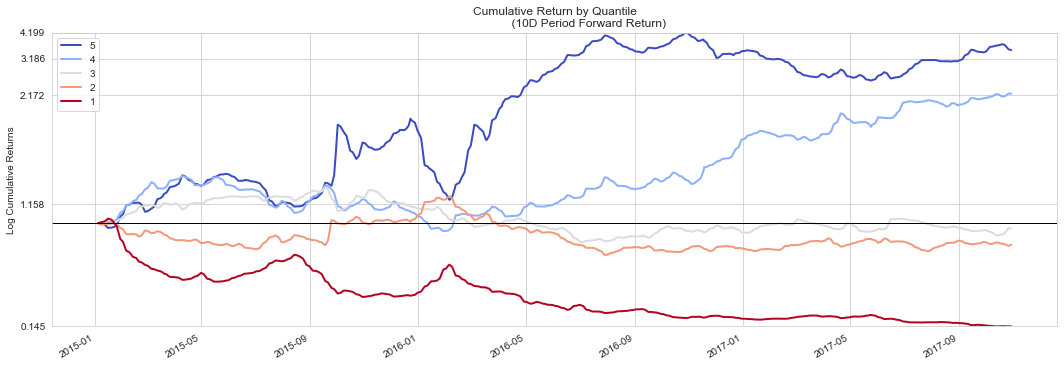

In [23]:
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_quantile_daily['10D'], period='10D', freq=None);

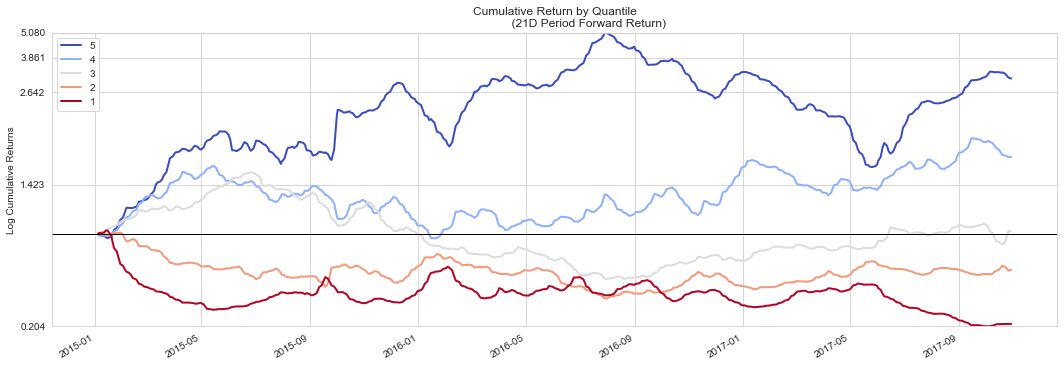

In [24]:
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_quantile_daily['21D'], period='21D', freq=None);

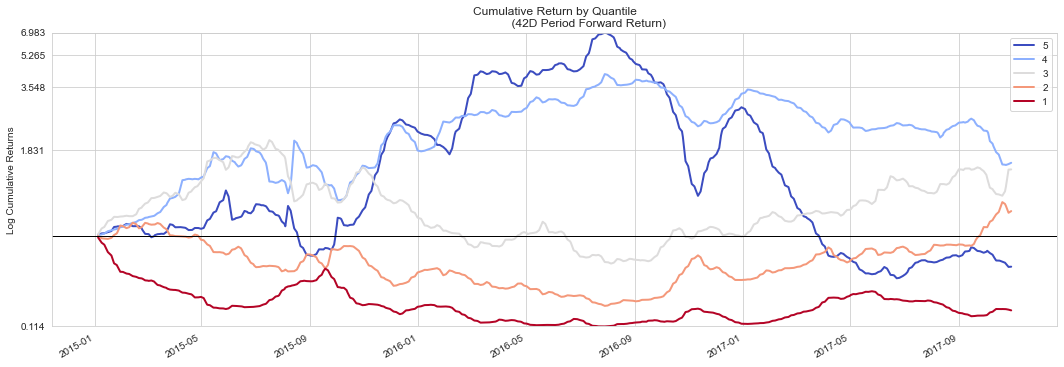

In [25]:
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_quantile_daily['42D'], period='42D', freq=None);

## Distribution of Returns by Holding Period and Quantile

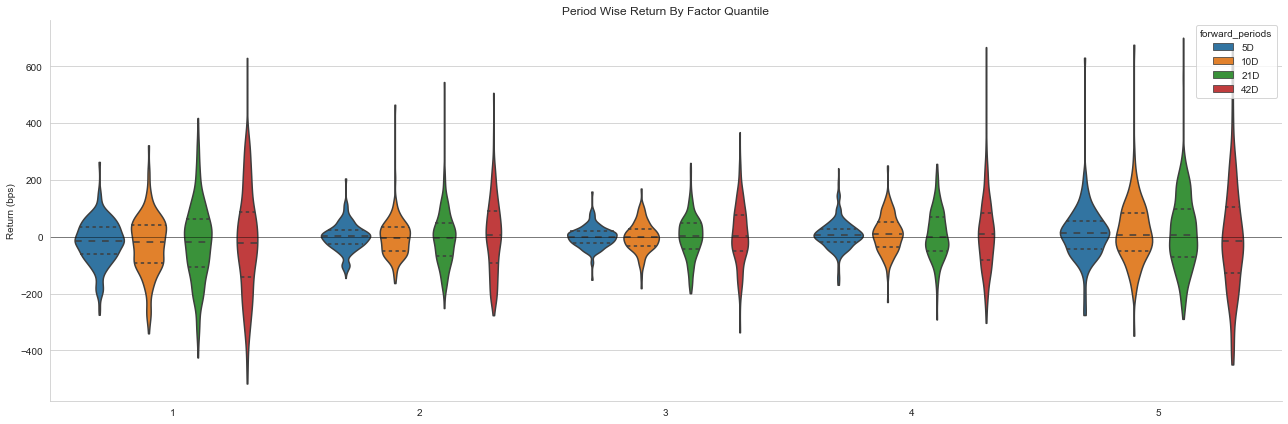

In [26]:
alphalens.plotting.plot_quantile_returns_violin(mean_return_by_quantile_daily)
plt.tight_layout()
sns.despine();

## Information Coefficient

The information coefficient is very important concept in investment management, and is often used to measure a manager's skill. It's actually pretty simple; the Information Coefficient is the correlation between the forecast and the actual returns. So...an information coefficient will be high if forecasts generally have the same *direction* as actual market movements, meaning the manager rarely makes losing investments. 

They are pretty easy to compute, and Alphalens makes it even easier. Alphalens uses Spearman Rank Coefficient, which is nonparametric. 

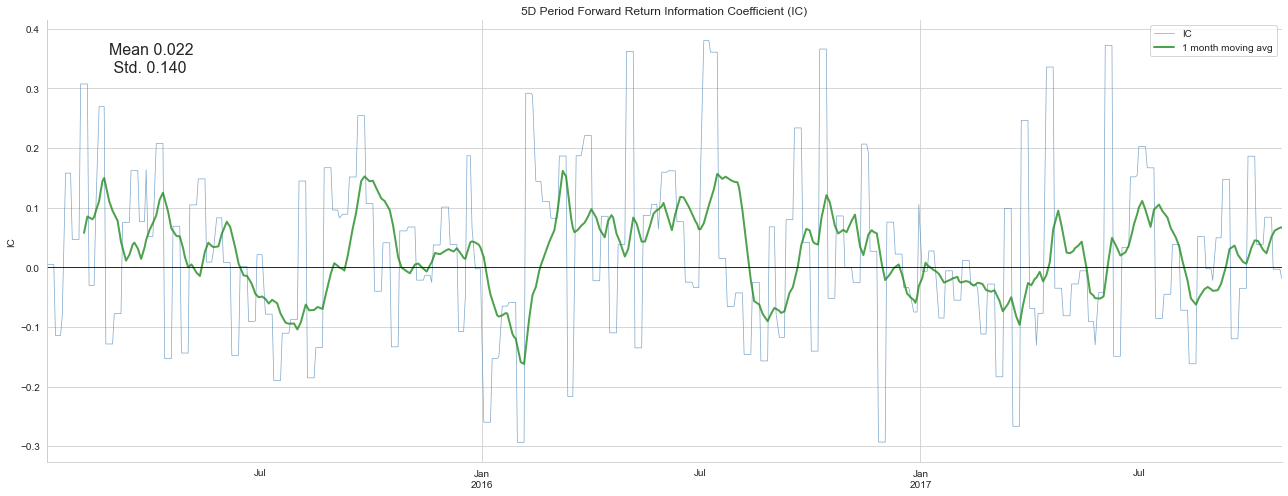

In [28]:
infcoefs = alphalens.performance.factor_information_coefficient(alphalens_data)
alphalens.plotting.plot_ic_ts(infcoefs[['5D']])
plt.tight_layout()
sns.despine();

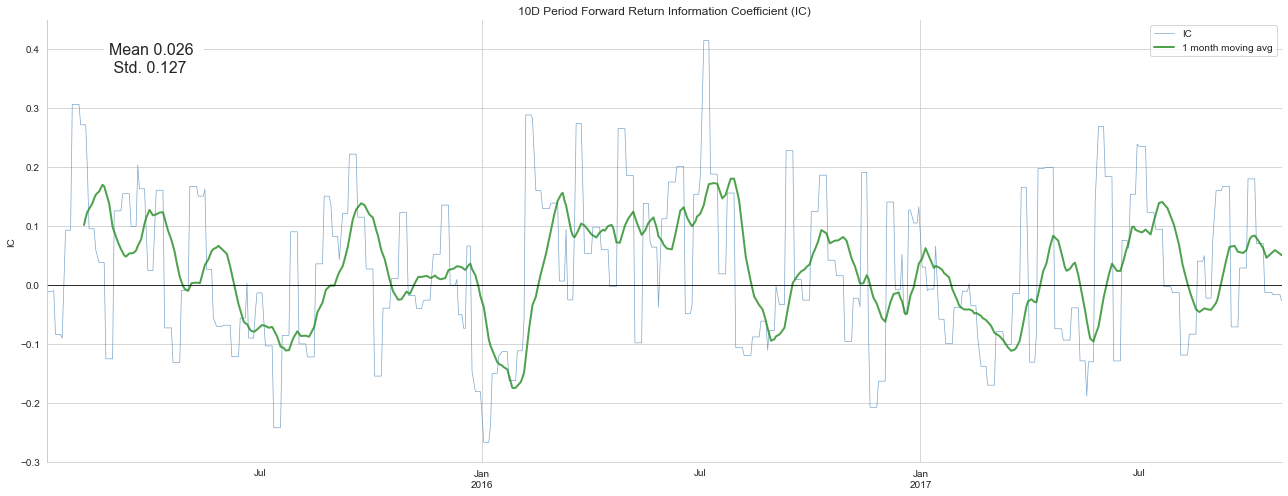

In [29]:
alphalens.plotting.plot_ic_ts(infcoefs[['10D']])
plt.tight_layout()
sns.despine();

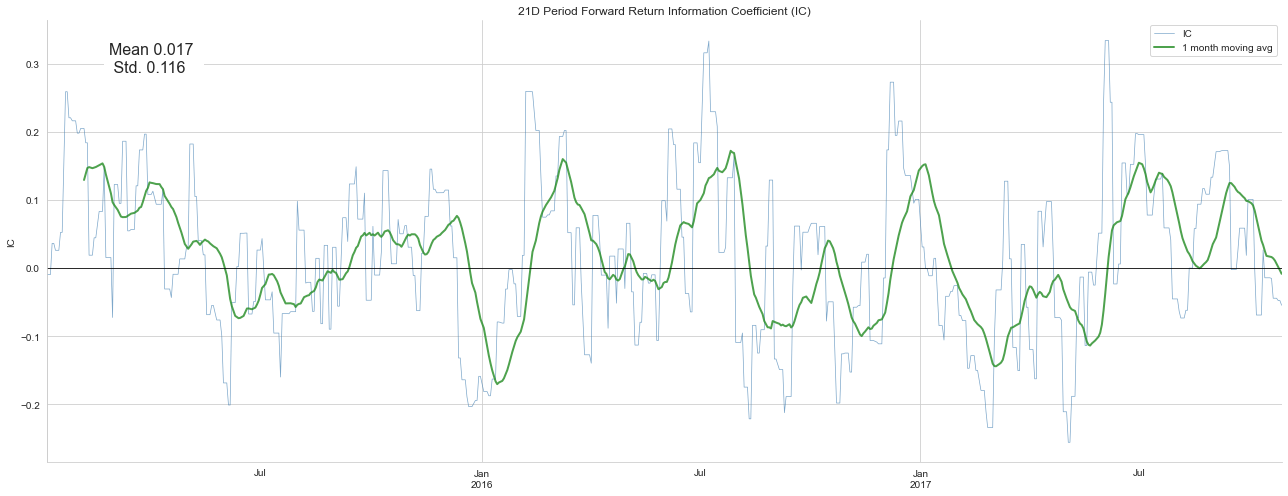

In [31]:
alphalens.plotting.plot_ic_ts(infcoefs[['21D']])
plt.tight_layout()
sns.despine();

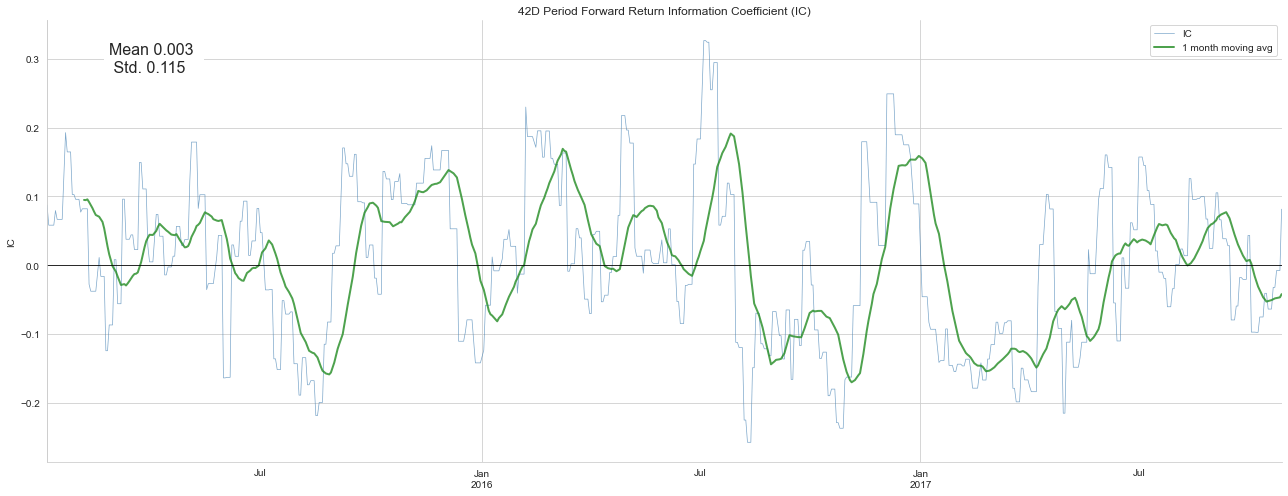

In [32]:
alphalens.plotting.plot_ic_ts(infcoefs[['42D']])
plt.tight_layout()
sns.despine();

In [34]:
# mean information coefficients
infcoefs.mean()

5D     0.022382
10D    0.026261
21D    0.017131
42D    0.003156
dtype: float64

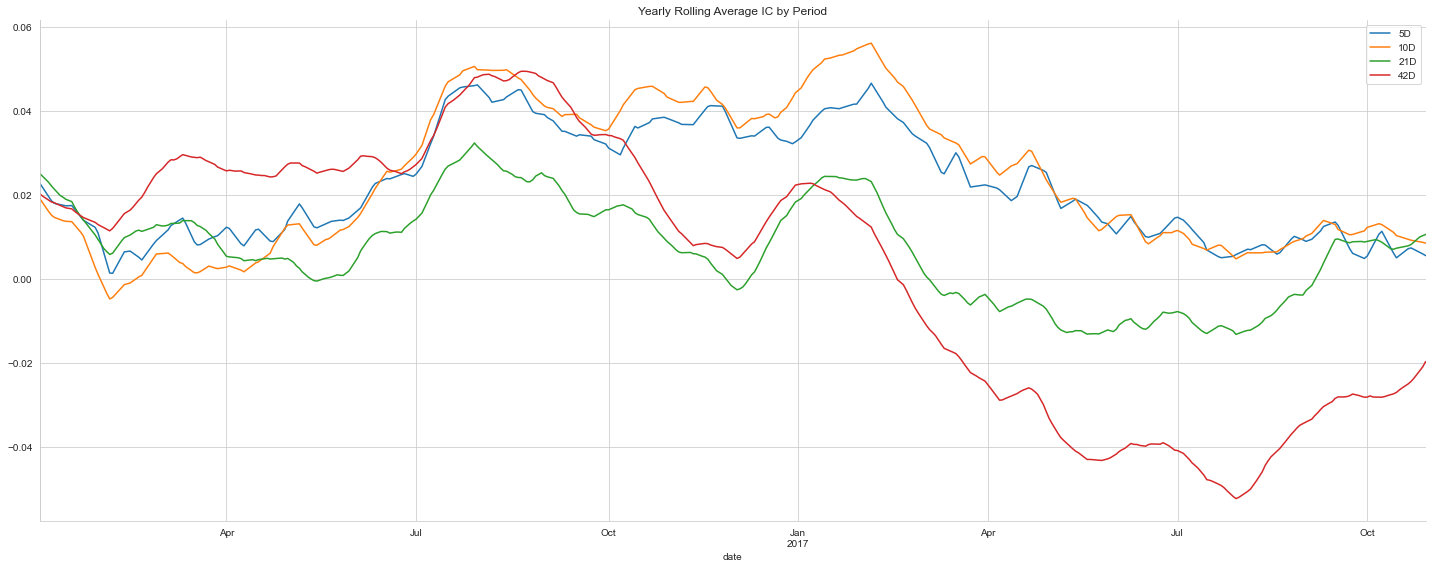

In [48]:
infcoefs.rolling(252).mean().dropna().plot(figsize=(20,8), title='Yearly Rolling Average IC by Period')
plt.tight_layout()
sns.despine();

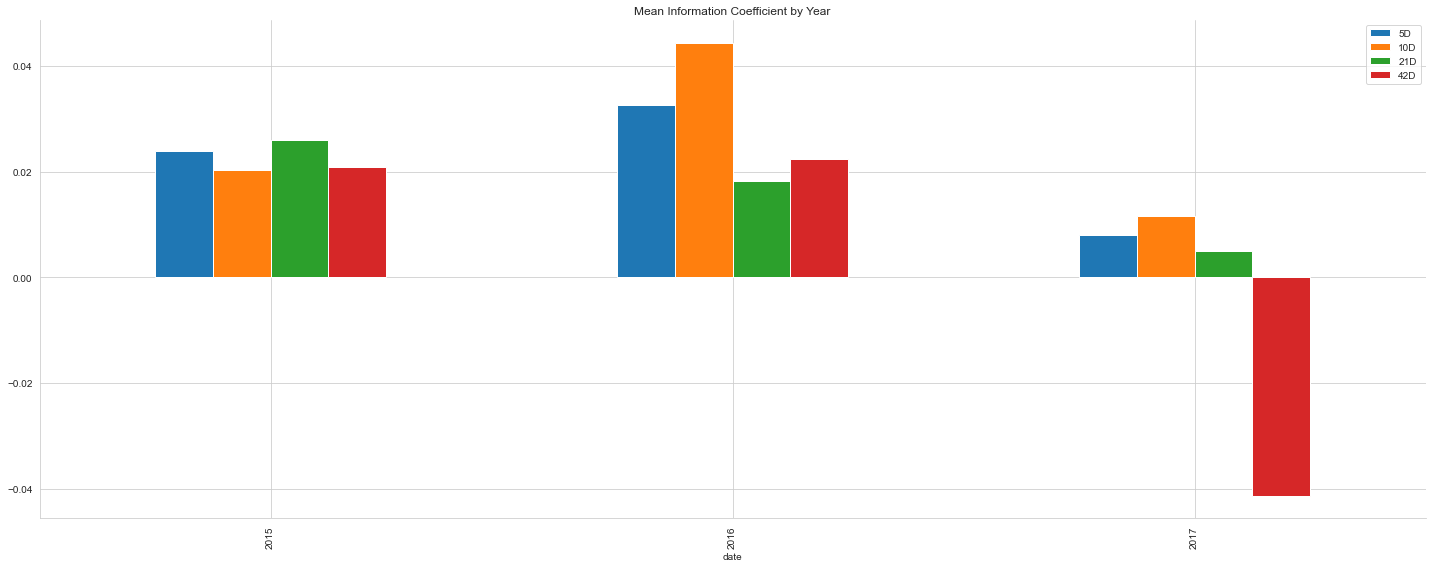

In [47]:
# compare annual IC
ic_annual = infcoefs.resample('A').mean()
ic_annual.index = ic_annual.index.year
ic_annual.plot.bar(figsize=(20,8))
plt.title('Mean Information Coefficient by Year')
plt.tight_layout()
sns.despine();

## Quantile Turnover

How often do the stocks in a given quantile change? That's the question we are answering here.

Turnover Analysis


,5D,10D,21D,42D
Quantile 1 Mean Turnover,0.411,0.590,0.830,0.831
Quantile 2 Mean Turnover,0.645,0.740,0.804,0.812
Quantile 3 Mean Turnover,0.679,0.765,0.808,0.812
Quantile 4 Mean Turnover,0.642,0.741,0.810,0.814
Quantile 5 Mean Turnover,0.394,0.569,0.811,0.819


,5D,10D,21D,42D
Mean Factor Rank Autocorrelation,0.713,0.454,-0.013,-0.017


<Figure size 432x288 with 0 Axes>

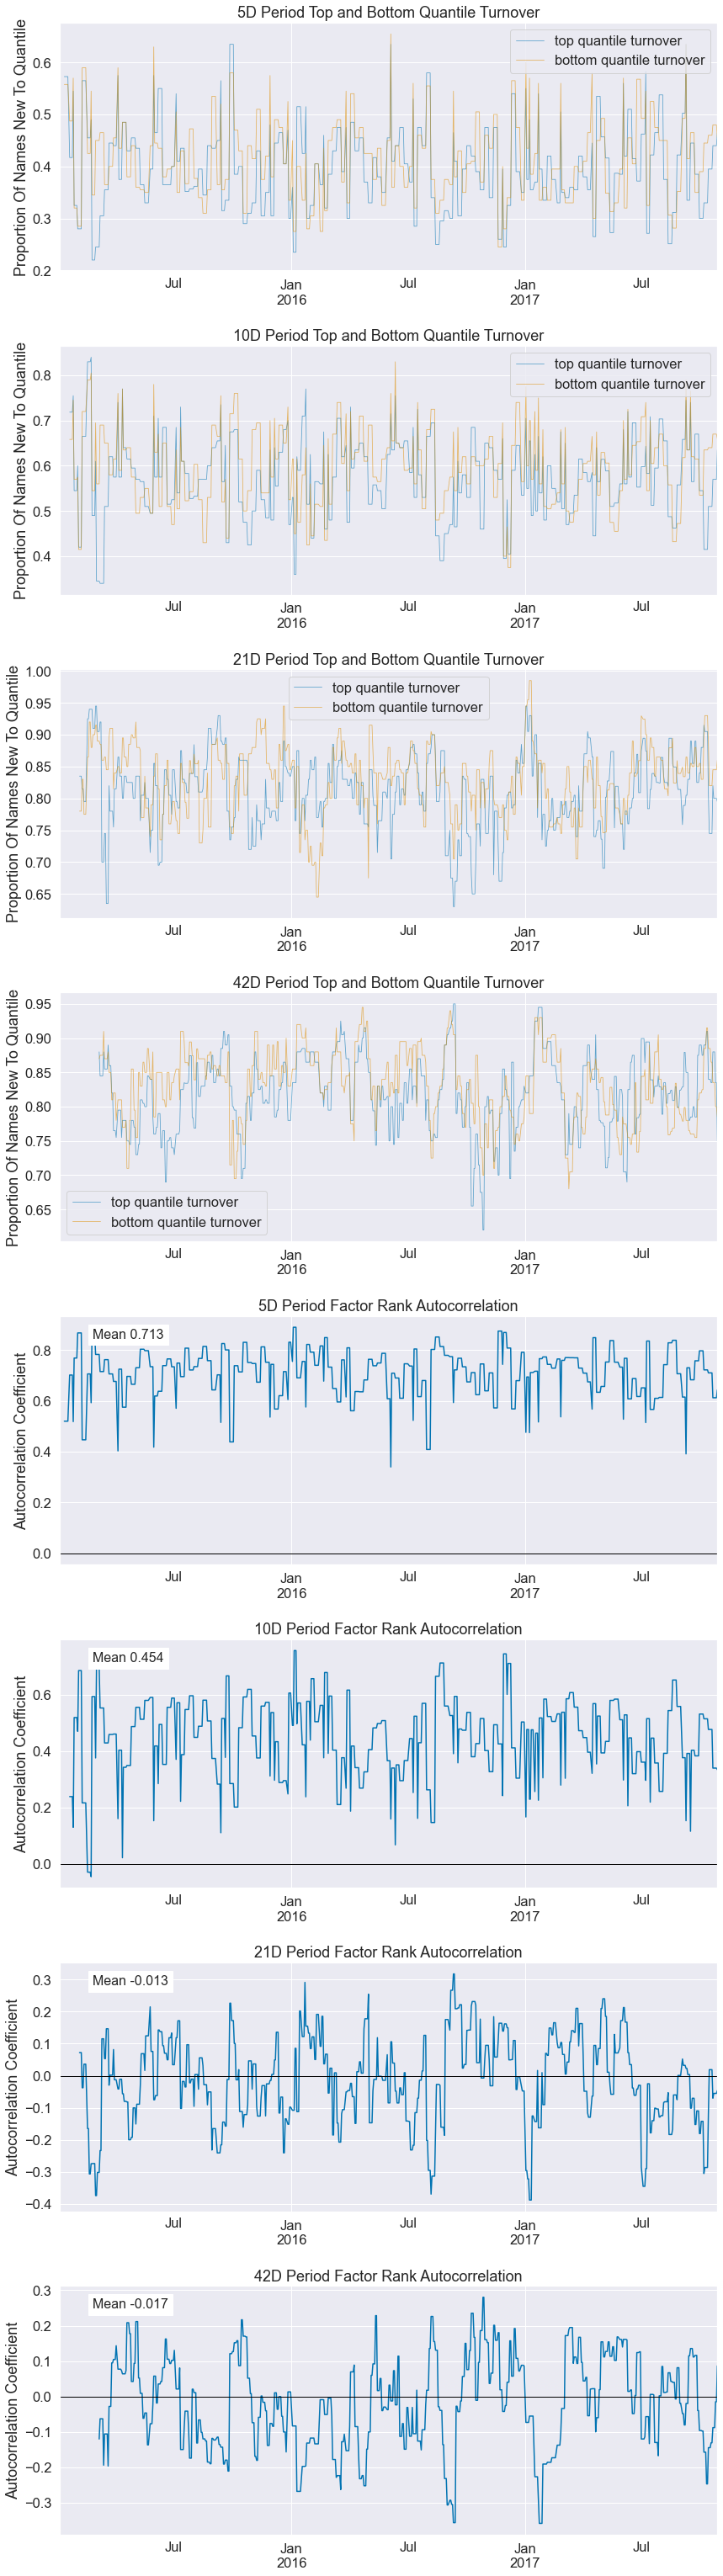

In [49]:
alphalens.tears.create_turnover_tear_sheet(alphalens_data)